## Trajectory analysis of GPS data - Kelowna (by SovereignAI) - Single day and multiple trajectory

In [1]:
import requests
import json
import time
import datetime
from urllib.request import urlopen
import requests
import warnings
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns
import osmnx as ox
import networkx as nx
import geopandas as gpd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pyproj import CRS
import os
import movingpandas as mpd
from shapely.geometry import Point

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read csv
'''
kelowna_gps = pd.read_csv('C:/data/gps_sai/Kelowna_Redo.csv')
'''
kelowna_gps_01Aug = pd.read_csv('C:/data/gps_sai/kelowna_gps_parts/kelowna_gps_2023-08-01.csv')

# Display
kelowna_gps_01Aug

,DateTime,registrationID,latitude,longitude,recordCount
0,2023-08-01 00:16:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489068,1
1,2023-08-01 00:22:51,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837950,-119.489083,1
2,2023-08-01 00:22:56,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489065,1
3,2023-08-01 00:28:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837937,-119.489076,1
4,2023-08-01 00:28:53,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837948,-119.489074,1
...,...,...,...,...,...
3107642,2023-08-01 14:59:45,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932582,-119.348280,4
3107643,2023-08-01 14:59:37,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932542,-119.348240,1
3107644,2023-08-01 14:59:46,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932546,-119.348220,1
3107645,2023-08-01 14:59:33,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932528,-119.348202,1


In [ ]:
def convert_df_to_gdf_v1(df, crs_no):
    # Create a geometry column from latitude and longitude and create gdf for Halifax
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    # Set the coordinate reference system (CRS) if needed
    gdf.set_crs(epsg=crs_no, inplace=True)  # WGS 84
    
    # Display
    return gdf

In [4]:
# CRS for the gdf
crs = 4326

kelowna_gps_01Aug = convert_df_to_gdf_v1(kelowna_gps_01Aug, crs)
kelowna_gps_01Aug

,DateTime,registrationID,latitude,longitude,recordCount,geometry
0,2023-08-01 00:16:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489068,1,POINT (-119.48907 49.83797)
1,2023-08-01 00:22:51,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837950,-119.489083,1,POINT (-119.48908 49.83795)
2,2023-08-01 00:22:56,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489065,1,POINT (-119.48906 49.83797)
3,2023-08-01 00:28:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837937,-119.489076,1,POINT (-119.48908 49.83794)
4,2023-08-01 00:28:53,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837948,-119.489074,1,POINT (-119.48907 49.83795)
...,...,...,...,...,...,...
3107642,2023-08-01 14:59:45,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932582,-119.348280,4,POINT (-119.34828 49.93258)
3107643,2023-08-01 14:59:37,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932542,-119.348240,1,POINT (-119.34824 49.93254)
3107644,2023-08-01 14:59:46,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932546,-119.348220,1,POINT (-119.34822 49.93255)
3107645,2023-08-01 14:59:33,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932528,-119.348202,1,POINT (-119.34820 49.93253)


In [ ]:
def drop_less_freq_ids(df, col_name, freq):
    # Drop duplicates
    df = df.drop_duplicates()

    # Count occurrences of each registrationID
    registration_counts = df[col_name].value_counts()

    # Identify IDs that occur less than 4 times
    less_freq_ids = registration_counts[registration_counts < freq].index

    # Calculate the number of such IDs
    num_less_freq_ids = len(less_freq_ids)

    # Drop rows with registrationIDs that occur only once
    df = df[~df[col_name].isin(less_freq_ids)]

    # Return
    return df, num_less_freq_ids


In [6]:
col_name = 'registrationID'
freq = 4

# Drop less frequent GPS columns
kelowna_gps_01Aug, num_thrice_occurrence_ids = drop_less_freq_ids(kelowna_gps_01Aug, col_name, freq)

# Calculate the number of such IDs
print(f"Number of registrationIDs occurring less than four times: {num_thrice_occurrence_ids}")


Number of registrationIDs occurring less than four times: 17806


In [ ]:
def drop_duplicate_gps(df, gps_col_name, date_col_name):
    # Drop duplicates
    df = df.drop_duplicates()
    df[date_col_name] = pd.to_datetime(df[date_col_name])

    # Shape before dropping duplicates
    rows_before = df.shape[0]

    # Drop rows with duplicate registrationID and DateTime
    df = df.drop_duplicates(subset=[gps_col_name, date_col_name])

    # Shape after dropping duplicates
    rows_after = df.shape[0]

    # Calculate and print the number of rows dropped
    rows_dropped = rows_before - rows_after
    
    # Display
    return df, rows_dropped
    

In [7]:

# Column name and count limit
gps_col_name = 'registrationID'
date_col_name = 'DateTime'

# Drop duplicates
kelowna_gps_01Aug, rows_dropped = drop_duplicate_gps(kelowna_gps_01Aug, gps_col_name, date_col_name)

print(f"Number of rows dropped: {rows_dropped}")
display(kelowna_gps_01Aug)

Number of rows dropped: 240200


,DateTime,registrationID,latitude,longitude,recordCount,geometry
0,2023-08-01 00:16:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489068,1,POINT (-119.48907 49.83797)
1,2023-08-01 00:22:51,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837950,-119.489083,1,POINT (-119.48908 49.83795)
2,2023-08-01 00:22:56,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837970,-119.489065,1,POINT (-119.48906 49.83797)
3,2023-08-01 00:28:50,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837937,-119.489076,1,POINT (-119.48908 49.83794)
4,2023-08-01 00:28:53,741e7426-d14c-3da4-a8ac-2e20e5ea7cfb,49.837948,-119.489074,1,POINT (-119.48907 49.83795)
...,...,...,...,...,...,...
3107642,2023-08-01 14:59:45,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932582,-119.348280,4,POINT (-119.34828 49.93258)
3107643,2023-08-01 14:59:37,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932542,-119.348240,1,POINT (-119.34824 49.93254)
3107644,2023-08-01 14:59:46,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932546,-119.348220,1,POINT (-119.34822 49.93255)
3107645,2023-08-01 14:59:33,9f8ac6f3-8425-36da-bba7-86dc38cc8590,49.932528,-119.348202,1,POINT (-119.34820 49.93253)


In [8]:
# Calculate the start and end times
start_time_k = kelowna_gps_01Aug['DateTime'].min()
end_time_k = kelowna_gps_01Aug['DateTime'].max()

print(f"kelowna_gps_01Aug data was collected from {start_time_k} to {end_time_k}.")

kelowna_gps_01Aug data was collected from 2023-08-01 00:00:00 to 2023-08-01 23:59:59.


In [ ]:
def display_shp_in_contextily_v1(path, crs, dim):
    # Read shapefile
    shp = gpd.read_file(path)
    
    # Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
    shp.to_crs(epsg=crs, inplace=True)
    
    # Plot the geometries on a basemap
    fig, ax = plt.subplots(figsize=(dim, dim))
    
    # Plot the roads (your data)
    shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)
    
    # Use OpenStreetMap for the basemap
    ctx.add_basemap(ax, crs=shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    
    # Show the plot
    plt.show()

    return 0


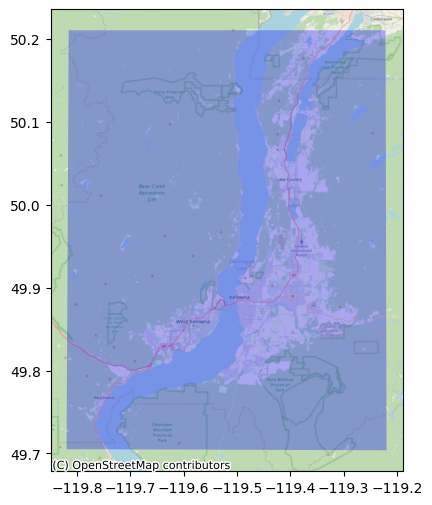

<module 'matplotlib.pyplot' from 'C:\\Users\\asen1\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

In [9]:

# Constant: SHP path and CRS value
path_to_shp = 'C:/data/boundaries_v2/inner_boundary_Kelowna.shp'
epsg = 4326

display_shp_in_contextily_v1(path_to_shp, epsg, 6)


In [ ]:
def convert_roads_geojson_to_osmnx_graphml_v1(path, crs_no):

    # Load the GeoJSON file
    roads_gdf = gpd.read_file(path)
    
    # Ensure CRS is WGS84 (EPSG:4326)
    roads_gdf = roads_gdf.to_crs(epsg=crs_no)
    
    # Initialize a directed graph
    roads_graphml = nx.MultiDiGraph()
    
    # Extract nodes and edges
    node_id = 0  # To uniquely identify nodes
    node_map = {}  # To store unique nodes and their IDs
    
    for _, row in roads_gdf.iterrows():
        if isinstance(row.geometry, LineString):
            # Extract coordinates from the LineString
            coords = list(row.geometry.coords)
            
            # Add nodes and edges to the graph
            for i in range(len(coords) - 1):
                u, v = coords[i], coords[i + 1]
                
                # Add nodes (check if they already exist)
                if u not in node_map:
                    node_map[u] = node_id
                    roads_graphml.add_node(node_id, x=u[0], y=u[1])
                    node_id += 1
                if v not in node_map:
                    node_map[v] = node_id
                    roads_graphml.add_node(node_id, x=v[0], y=v[1])
                    node_id += 1
                
                # Add edge with attributes
                roads_graphml.add_edge(node_map[u], node_map[v], length=LineString([u, v]).length)
        else:
            print(f"Skipping non-LineString geometry at index {_}")

    if crs_no == 4326:
        # Add CRS to the graph
        roads_graphml.graph['crs'] = "EPSG:4326"
    else:
        print('The crs_no is not 4326; skipping graph[crs] addition')

    return roads_graphml


Skipping non-LineString geometry at index 0
Skipping non-LineString geometry at index 1
Skipping non-LineString geometry at index 2
Skipping non-LineString geometry at index 3
Skipping non-LineString geometry at index 4
Skipping non-LineString geometry at index 5
Skipping non-LineString geometry at index 6
Skipping non-LineString geometry at index 7
Skipping non-LineString geometry at index 8
Skipping non-LineString geometry at index 9
Skipping non-LineString geometry at index 10
Skipping non-LineString geometry at index 11
Skipping non-LineString geometry at index 12
Skipping non-LineString geometry at index 13
Skipping non-LineString geometry at index 14
Skipping non-LineString geometry at index 15
Skipping non-LineString geometry at index 16
Skipping non-LineString geometry at index 17
Skipping non-LineString geometry at index 18
Skipping non-LineString geometry at index 19


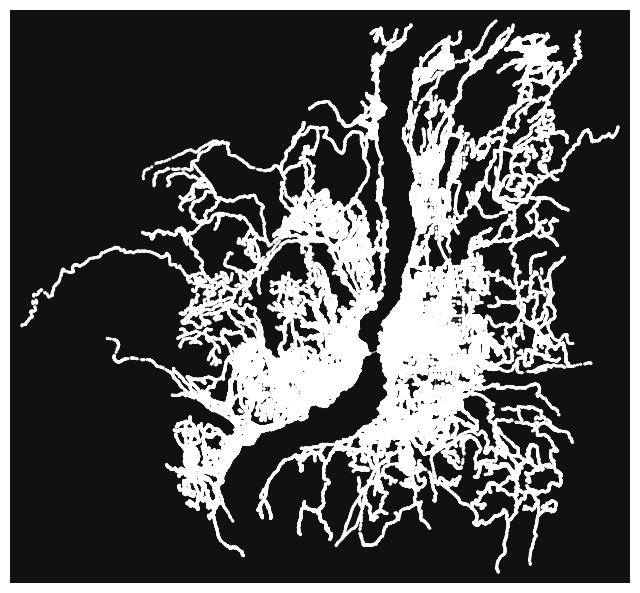

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
import geopandas as gpd
import networkx as nx
import osmnx as ox

# Constants
path = "C:/data/gps_sai/bc_gis/kelowna_roads_1.geojson"
crs = 4326

# Convert to graphml
roads_kelowna_json = convert_roads_geojson_to_osmnx_graphml_v1(path, crs)

# Save the graph as a GraphML file (optional)
ox.save_graphml(roads_kelowna_json, "C:/data/gps_sai/bc_gis/kelowna_roads_1.graphml")

# Visualize the graph (optional)
ox.plot_graph(roads_kelowna_json, node_size=5, edge_linewidth=0.5)


In [12]:
# Importing road network from pytrack's graph module
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely.geometry import Point, LineString

from cybstr.pytrack.graph import graph, distance
from cybstr.pytrack.analytics import visualization
from cybstr.pytrack.matching import candidate, mpmatching_utils, mpmatching

# Get Kelowna boundary shapefile
kelowna_boundary = gpd.read_file('C:/data/boundaries_v2/inner_boundary_Kelowna.shp')

# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
kelowna_boundary.to_crs(epsg=4326, inplace=True)

# Get the bounding box again
minx, miny, maxx, maxy = kelowna_boundary.total_bounds

# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(roads_kelowna_json)

latitude = kelowna_gps_01Aug["latitude"].to_list()
longitude = kelowna_gps_01Aug["longitude"].to_list()

# Convert to north, south, east, and west
north = maxy  # Maximum latitude
south = miny  # Minimum latitude
east = maxx   # Maximum longitude
west = minx   # Minimum longitude

points = [(lat, lon) for lat, lon in zip(latitude[:30], longitude[:30])]
roads_kelowna_json = graph.graph_from_bbox(*distance.enlarge_bbox(north, south, west, east, 500), simplify=True, network_type='drive')

Downloaded 10,000.52kB


In [13]:
# Visualize the roads in pytrack's map module
loc = (np.mean(latitude[:30]), np.mean(longitude[:30]))
maps = visualization.Map(location=loc, zoom_start=15)
maps.add_graph(roads_kelowna_json, plot_nodes=True)
# maps

In [ ]:
def calculate_trip_id(df, gps_col_name, date_col_name, timelimt):

    # Convert DateTime column to datetime type
    df[date_col_name] = pd.to_datetime(df[date_col_name])
    
    # Sort by registrationID and DateTime to ensure proper order
    df = df.sort_values(by=[gps_col_name, date_col_name])
    
    # Calculate time difference in seconds between consecutive rows
    df.loc[:,"time_diff"] = df[date_col_name].diff().dt.total_seconds()
    
    # Assign trip_id based on the desired time gap
    df.loc[:,"trip_id"] = (df["time_diff"] > timelimt).cumsum() + 1
    
    # Fill NaN for the first row's time_diff
    df.loc[:,"time_diff"] = df["time_diff"].fillna(0)

    # Return the df
    return df


In [15]:
# Assign trip_ids based on 1hr gap between consecutive GPS points
# Constants: column names and time limit trip
gps_col_name = "registrationID"
date_col_name = "DateTime"
timelimt = 3600

# Return and print the df
kelowna_gps_01Aug_id1 = calculate_trip_id(kelowna_gps_01Aug_id1, gps_col_name, date_col_name, timelimt)
display(kelowna_gps_01Aug_id1.head())

C:\Users\asen1\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,DateTime,registrationID,latitude,longitude,recordCount,geometry,time_diff,trip_id
1426961,2023-08-01 01:07:16,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.937629,-119.390821,2,POINT (-119.39082 49.93763),0.0,1
2283440,2023-08-01 01:08:52,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.925300,-119.386567,2,POINT (-119.38657 49.92530),96.0,1
1501746,2023-08-01 01:10:43,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.914935,-119.392399,2,POINT (-119.39240 49.91493),111.0,1
1122680,2023-08-01 01:11:39,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.907666,-119.403026,2,POINT (-119.40303 49.90767),56.0,1
1565775,2023-08-01 01:26:05,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.883591,-119.475779,2,POINT (-119.47578 49.88359),866.0,1


In [16]:
# Ensure geometry column contains Point objects
import geopandas as gpd

kelowna_gps_01Aug_id1 = gpd.GeoDataFrame(kelowna_gps_01Aug_id1, geometry=gpd.points_from_xy(kelowna_gps_01Aug_id1.longitude, kelowna_gps_01Aug_id1.latitude), crs="EPSG:4326")
kelowna_gps_01Aug_id1 = kelowna_gps_01Aug_id1.reset_index()

# Check if the geometry column is valid
if isinstance(kelowna_gps_01Aug_id1, gpd.GeoDataFrame):
    # Extract x (longitude) and y (latitude) from the geometry column
    kelowna_gps_01Aug_id1["x"] = kelowna_gps_01Aug_id1.geometry.x
    kelowna_gps_01Aug_id1["y"] = kelowna_gps_01Aug_id1.geometry.y
else:
    raise ValueError("kelowna_gps_01Aug_id1 must be a GeoDataFrame with a valid geometry column.")

display(kelowna_gps_01Aug_id1.head())

,index,DateTime,registrationID,latitude,longitude,recordCount,geometry,time_diff,trip_id,x,y
0,1426961,2023-08-01 01:07:16,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.937629,-119.390821,2,POINT (-119.39082 49.93763),0.0,1,-119.390821,49.937629
1,2283440,2023-08-01 01:08:52,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.925300,-119.386567,2,POINT (-119.38657 49.92530),96.0,1,-119.386567,49.925300
2,1501746,2023-08-01 01:10:43,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.914935,-119.392399,2,POINT (-119.39240 49.91493),111.0,1,-119.392399,49.914935
3,1122680,2023-08-01 01:11:39,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.907666,-119.403026,2,POINT (-119.40303 49.90767),56.0,1,-119.403026,49.907666
4,1565775,2023-08-01 01:26:05,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.883591,-119.475779,2,POINT (-119.47578 49.88359),866.0,1,-119.475779,49.883591


In [17]:
kelowna_gps_01Aug_id1_t1 = kelowna_gps_01Aug_id1[kelowna_gps_01Aug_id1['trip_id'] == 1] # Test: use trip_id 1

display(kelowna_gps_01Aug_id1_t1)

,index,DateTime,registrationID,latitude,longitude,recordCount,geometry,time_diff,trip_id,x,y
0,1426961,2023-08-01 01:07:16,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.937629,-119.390821,2,POINT (-119.39082 49.93763),0.0,1,-119.390821,49.937629
1,2283440,2023-08-01 01:08:52,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.925300,-119.386567,2,POINT (-119.38657 49.92530),96.0,1,-119.386567,49.925300
2,1501746,2023-08-01 01:10:43,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.914935,-119.392399,2,POINT (-119.39240 49.91493),111.0,1,-119.392399,49.914935
3,1122680,2023-08-01 01:11:39,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.907666,-119.403026,2,POINT (-119.40303 49.90767),56.0,1,-119.403026,49.907666
4,1565775,2023-08-01 01:26:05,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.883591,-119.475779,2,POINT (-119.47578 49.88359),866.0,1,-119.475779,49.883591
5,987835,2023-08-01 01:30:52,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.884683,-119.493565,2,POINT (-119.49357 49.88468),287.0,1,-119.493565,49.884683
6,989223,2023-08-01 01:31:03,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.885212,-119.493578,2,POINT (-119.49358 49.88521),11.0,1,-119.493578,49.885212
7,989855,2023-08-01 01:31:21,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.886134,-119.493580,2,POINT (-119.49358 49.88613),18.0,1,-119.493580,49.886134
8,1884695,2023-08-01 01:31:33,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.886909,-119.493615,2,POINT (-119.49362 49.88691),12.0,1,-119.493615,49.886909
9,1884706,2023-08-01 01:31:48,000cd9a7-cab0-3022-bd6a-ec9a82440c94,49.887213,-119.494025,2,POINT (-119.49402 49.88721),15.0,1,-119.494025,49.887213


In [18]:
# Initialize maps
# Retrieve all lat/long and make a list
lati_01Aug_id1_t1 = kelowna_gps_01Aug_id1_t1["latitude"].to_list()
long_01Aug_id1_t1 = kelowna_gps_01Aug_id1_t1["longitude"].to_list()

points_01Aug_id1_t1 = [(lat, lon) for lat, lon in zip(lati_01Aug_id1_t1[:30], long_01Aug_id1_t1[:30])]

# Center map around mean latitude and longitude
loc_01Aug_id1_t1 = (np.mean(lati_01Aug_id1_t1[:30]), np.mean(long_01Aug_id1_t1[:30]))
maps_01Aug_id1_t1 = visualization.Map(location=loc_01Aug_id1_t1, zoom_start=15)
#maps_01Aug_id1_t1

In [28]:
# Function to get connected subgraphs

def connected_component_subgraphs(G):
    for c in nx.weakly_connected_components(G):
        yield G.subgraph(c)

# Take the largest connected subgraph
sgs = list(connected_component_subgraphs(roads_kelowna_json))
i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)


13917

<H3>Part J2.2: Trajectory for all IDs in a day</H3>

In [25]:
# Constants: column names and time limit trip
gps_col_name = "registrationID"
date_col_name = "DateTime"
timelimt = 3600

# Return and print the df
kelowna_gps_01Aug = calculate_trip_id(kelowna_gps_01Aug, gps_col_name, date_col_name, timelimt)
display(kelowna_gps_01Aug.head())


,DateTime,registrationID,latitude,longitude,recordCount,geometry,time_diff,trip_id
0,2023-08-01 05:48:08,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,4,POINT (-119.40210 50.02430),0.0,1
1,2023-08-01 05:48:56,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,1,POINT (-119.40210 50.02430),48.0,1
2,2023-08-01 05:49:49,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,1,POINT (-119.40210 50.02430),53.0,1
3,2023-08-01 05:52:13,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,3,POINT (-119.40210 50.02430),144.0,1
4,2023-08-01 05:52:56,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,1,POINT (-119.40210 50.02430),43.0,1
...,...,...,...,...,...,...,...,...
2835895,2023-08-01 01:59:28,ffff972d-3f41-379b-81b9-b4220f4d7bb4,49.9497,-119.4339,2,POINT (-119.43390 49.94970),-64933.0,75659
2835896,2023-08-01 02:00:15,ffff972d-3f41-379b-81b9-b4220f4d7bb4,49.9497,-119.4339,3,POINT (-119.43390 49.94970),47.0,75659
2835897,2023-08-01 02:01:42,ffff972d-3f41-379b-81b9-b4220f4d7bb4,49.9497,-119.4339,2,POINT (-119.43390 49.94970),87.0,75659
2835898,2023-08-01 02:02:31,ffff972d-3f41-379b-81b9-b4220f4d7bb4,49.9497,-119.4339,3,POINT (-119.43390 49.94970),49.0,75659


In [26]:
# Ensure geometry column contains Point objects
import geopandas as gpd

kelowna_gps_01Aug = gp.GeoDataFrame(kelowna_gps_01Aug, geometry=gp.points_from_xy(kelowna_gps_01Aug.longitude, kelowna_gps_01Aug.latitude), crs="EPSG:4326")
kelowna_gps_01Aug = kelowna_gps_01Aug.reset_index()

# Check if the geometry column is valid
if isinstance(kelowna_gps_01Aug, gpd.GeoDataFrame):
    # Extract x (longitude) and y (latitude) from the geometry column
    kelowna_gps_01Aug["x"] = kelowna_gps_01Aug.geometry.x
    kelowna_gps_01Aug["y"] = kelowna_gps_01Aug.geometry.y
else:
    raise ValueError("kelowna_gps_01Aug must be a GeoDataFrame with a valid geometry column.")

display(kelowna_gps_01Aug.head())

,index,DateTime,registrationID,latitude,longitude,recordCount,geometry,time_diff,trip_id,x,y
0,0,2023-08-01 05:48:08,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,4,POINT (-119.40210 50.02430),0.0,1,-119.4021,50.0243
1,1,2023-08-01 05:48:56,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,1,POINT (-119.40210 50.02430),48.0,1,-119.4021,50.0243
2,2,2023-08-01 05:49:49,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,1,POINT (-119.40210 50.02430),53.0,1,-119.4021,50.0243
3,3,2023-08-01 05:52:13,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,3,POINT (-119.40210 50.02430),144.0,1,-119.4021,50.0243
4,4,2023-08-01 05:52:56,000080c4-07f2-3ef4-96b4-309eeadb0a9a,50.0243,-119.4021,1,POINT (-119.40210 50.02430),43.0,1,-119.4021,50.0243


In [27]:
# Retrieve all lat/long and make a list
latitude_kelowna_gps_01Aug = kelowna_gps_01Aug["latitude"].to_list()
longitude_kelowna_gps_01Aug = kelowna_gps_01Aug["longitude"].to_list()

points_kelowna_gps_01Aug = [(lat, lon) for lat, lon in zip(latitude_kelowna_gps_01Aug[:30], longitude_kelowna_gps_01Aug[:30])]

# Center map around mean latitude and longitude
loc = (np.mean(latitude_kelowna_gps_01Aug[:30]), np.mean(longitude_kelowna_gps_01Aug[:30]))
maps = visualization.Map(location=loc, zoom_start=15)
#maps

In [61]:

failed_trips = []

# Call the function to map-match and create a GeoDataFrame
matched_trips_gdf, failed_trips = map_match_and_return_geodataframe_v3(
    df=kelowna_gps_01Aug,
    log_name="kelowna_01Aug",
    graph=roads_kelowna_json, 
    day_col="DateTime", 
    gps_id_col="registrationID", 
    trip_id_col="trip_id", 
    interp_dist=50, 
    radius=90, 
    max_trips=10
)


Processing trip 10/10...


In [62]:
matched_trips_gdf

,day,gps_id,trip_id,geometry
0,2023-08-01 05:48:08,000080c4-07f2-3ef4-96b4-309eeadb0a9a,1,"LINESTRING (-119.41354 49.88509, -119.41355 49..."
1,2023-08-01 23:45:59,000745e3-8705-379c-a895-3b07ca43c49f,5,"LINESTRING (-119.41354 49.88509, -119.41355 49..."
2,2023-08-01 20:24:18,00085cc6-04e5-3573-87fd-98a063765705,8,"LINESTRING (-119.48957 49.89547, -119.48902 49..."


In [35]:
# Save/load the trips dataframe
'''
matched_trips_gdf.to_csv('matched_trips_gdf.csv')
matched_trips_gdf.head()
'''
'''
matched_trips_df = df.read_csv()
# convert to gdf?
'''

,day,gps_id,trip_id,geometry
0,2023-08-01,000080c4-07f2-3ef4-96b4-309eeadb0a9a,1,"LINESTRING (-119.41354 49.88509, -119.41355 49..."
1,2023-08-01,000745e3-8705-379c-a895-3b07ca43c49f,5,"LINESTRING (-119.41354 49.88509, -119.41355 49..."
2,2023-08-01,00085cc6-04e5-3573-87fd-98a063765705,8,"LINESTRING (-119.48957 49.89547, -119.48902 49..."
3,2023-08-01,000cd9a7-cab0-3022-bd6a-ec9a82440c94,19,"LINESTRING (-119.49428 49.88632, -119.49350 49..."
4,2023-08-01,001218a6-c679-36f1-8149-028f1fc79457,26,"LINESTRING (-119.44206 49.93414, -119.44203 49..."


In [41]:
# Visualize the trips in folium
###############################

folium_map = visualize_trips_in_folium(
    trips_gdf=matched_trips_gdf,  # GeoDataFrame from the map-matching function
    trip_id_col="trip_id"         # Column containing trip IDs
)

# Save and display the map
folium_map.save("matched_trips_folium_map_1000.html")

C:\Users\asen1\AppData\Local\Temp\ipykernel_26836\3015349705.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lat = trips_gdf.geometry.centroid.y.mean()
C:\Users\asen1\AppData\Local\Temp\ipykernel_26836\3015349705.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lon = trips_gdf.geometry.centroid.x.mean()


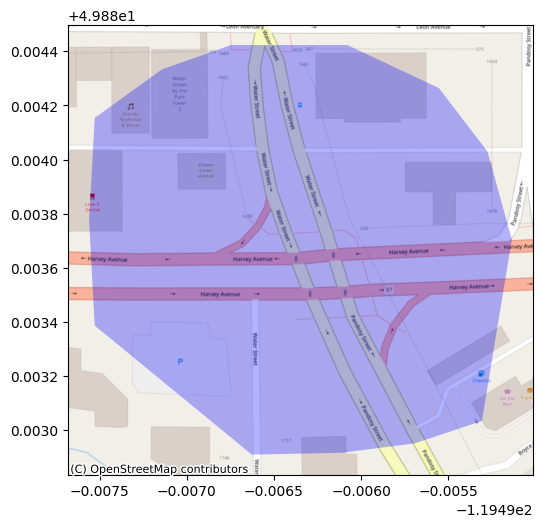

In [46]:

import contextily as ctx

path = 'C:/data/gps_sai/bc_gis/junctions/Kelowna_Water_Harvey_Pandosy_Junc.shp'

shp = gpd.read_file(path)
    
# Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
shp.to_crs(epsg=4326, inplace=True)
    
# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(6, 6))
    
# Plot the roads (your data)
shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)
    
# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    
# Show the plot
plt.show()

In [49]:
# Find out how many linestrings from the trajectory gdb is crossing the junction

# Perform the spatial join to find intersecting linestrings
intersecting_trajectories = gpd.sjoin(matched_trips_gdf, shp, how="inner", predicate="intersects")

# Remove duplicates to get unique linestrings that pass through intersections
unique_intersecting_trajectories = intersecting_trajectories.drop_duplicates(subset=["gps_id", "trip_id"])

# Count the Number of Intersecting Trajectories
num_intersecting_trajectories = unique_intersecting_trajectories.shape[0]
print(f"Number of trajectories passing through intersections: {num_intersecting_trajectories}")


Number of trajectories passing through intersections: 8


In [57]:
# Visualize the trips in folium

folium_map = visualize_trips_in_folium(
    trips_gdf=unique_intersecting_trajectories,  # GeoDataFrame from the map-matching function
    trip_id_col="trip_id"         # Column containing trip IDs
)

# Save and display the map
folium_map.save("matched_trips_folium_map_1000_unique_intersecting_trajectories.html")

C:\Users\asen1\AppData\Local\Temp\ipykernel_26836\3015349705.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lat = trips_gdf.geometry.centroid.y.mean()
C:\Users\asen1\AppData\Local\Temp\ipykernel_26836\3015349705.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  avg_lon = trips_gdf.geometry.centroid.x.mean()
